# Copernicus Climate Change Service (C3S) - Upper Air Data Service 

**Contains modified Copernicus Climate Change Service Information 2020**
under [License](https://apps.ecmwf.int/datasets/licences/copernicus/)

*Copernicus Climate Change Service (C3S) - Upper Air Data Service (2020)*

This IPython Notebook is intended for demonstration purposes and example usage of the Homogenization software for Radiosonde humidity data.
For further information please refer to the Deliverable Document or the script `raso_adj_cdm_v1.py` on [Github CEUAS](https://github.com/MBlaschek/CEUAS/tree/master/CEUAS/public/adjust), please note that there is an earlier version `raso_adj_cdm_v0.py`, which was used in Deliverable *DC3S311c_Lot2.2.4.2*.

 Table of Contents:
* [Downloading of data](#Downloading-of-data)
* [Investigating the data](#Investigating-the-data)
* [Running the Homogenization software](#Running-the-Homogenization-software)
* [Investigating results](#Investigating-results)

Updated on 24.6.2021 by MB.

Changes:
- Can download the files via the CDS API
- performance update
- quantile adjustments
- error fixes

In [1]:
# check if necessary packages are installed
# it is recommened to use an anaconda distribution of python
!pip -q install numpy pandas xarray matplotlib

In [2]:
# Notebook plotting
%pylab inline
import warnings
warnings.simplefilter("ignore")

Populating the interactive namespace from numpy and matplotlib


# Downloading of data

Following the instructions from [Example of CDS-Frontend](../cds-frontend/Example.ipynb) a request will be queued via the CDS. Please ensure valid credentials.

The CDSAPI requires a `.cdsapirc` file. Please [register](https://cds.climate.copernicus.eu/user/register?destination=%2F%23!%2Fhome) at the CDS and follow the "[How-to](https://cds.climate.copernicus.eu/api-how-to)" to allow the API access.


A typical request should contain:
1. **statid** - the Station Identifier
2. **date** - datetime selection YYYYMMDD
3. **pressure_level** - selection of pressure levels
4. **variable** - selection of variables 
5. **fbstats**  - feedback information from reanalysis

In [3]:
import cdsapi, zipfile, os, time
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning) # just cosmetics

# Please note: Server URL will be omitted, once published
c = cdsapi.Client(url='https://sis-dev.climate.copernicus.eu/api/v2')

In [4]:
t0 = time.time()
# Start Request
r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
               {
                   'variable': ["air_temperature", "air_relative_humidity"],
                   'statid': '10393',
                   'period': '1900-01-01/2021-01-01',
                   'optional': ["obs_minus_bg", "obs_minus_an", "bias_estimate"],
               })
# Start Download
r.download(target='download.zip')
# Check file size
assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
# Unzip the Data Stream
z = zipfile.ZipFile('download.zip')
print("Unzipping retrieved files: to ./exampla_data/1")
print(z.namelist())
z.extractall(path='./example_data/1')
z.close()
os.remove('download.zip')
print("Time elapsed: ", time.time()-t0, "s")

2022-01-20 09:09:45,914 INFO Welcome to the CDS
2022-01-20 09:09:45,916 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


Exception: <html>
<head><title>401 Authorization Required</title></head>
<body bgcolor="white">
<center><h1>401 Authorization Required</h1></center>
<hr><center>nginx/1.14.2</center>
</body>
</html>


In [6]:
# Show the new downloaded files in example_data directory
!ls -lhR example_data/1

example_data/1:
total 113M
-rw-r--r--. 1 mblaschek users 61M Jun 25 14:18 dest_0-20000-0-72357_air_temperature.nc
-rw-r--r--. 1 mblaschek users 53M Jun 25 14:18 dest_0-20000-0-72357_relative_humidity.nc


In [7]:
# Example output of retrieved NetCDF file
!ncdump -h example_data/1/dest_0-20000-0-72357_air_temperature.nc

netcdf dest_0-20000-0-72357_air_temperature {
dimensions:
	obs = 1259548 ;
	string11 = 11 ;
	string14 = 14 ;
	string28 = 28 ;
	time = 1259548 ;
	trajectory = 24449 ;
variables:
	float bias_estimate(obs) ;
		bias_estimate:cdmname = "era5fb/biascorr@body" ;
		bias_estimate:units = "K" ;
		bias_estimate:coordinates = "lat lon time plev" ;
		bias_estimate:cdsname = "bias_estimate" ;
		bias_estimate:standard_name = "air_temperature" ;
		bias_estimate:long_name = "ERA5 reanalysis bias_estimate" ;
	float lat(obs) ;
		lat:cdmname = "observations_table/latitude" ;
		lat:units = "degree_north" ;
		lat:standard_name = "latitude" ;
	float lon(obs) ;
		lon:cdmname = "observations_table/longitude" ;
		lon:units = "degree_east" ;
		lon:standard_name = "longitude" ;
	int obs(obs) ;
	float obs_minus_an(obs) ;
		obs_minus_an:cdmname = "era5fb/an_depar@body" ;
		obs_minus_an:units = "K" ;
		obs_minus_an:coordinates = "lat lon time plev" ;
		obs_minus_an:cdsname = "obs_minus_an" ;
		obs_minus_an:standard_

# Investigating the data

At the moment (01.2020), the database is at version 0, however, the data files seen here will be very similar to the ones delivered by the end of the contract.

The following shows how to open these files and read information. These are very common routines for data analysis. NetCDF can be read by numerous packages in Python. Xarray proves to be the most useful at the moment.


In [8]:
import xarray as xr

2021-06-25 14:19:08,936 INFO ecCodes library found using name '/usr/local/lib/libeccodes.so'.


In [9]:
tdata = xr.load_dataset('example_data/1/dest_0-20000-0-72357_air_temperature.nc')

In [10]:
rdata = xr.load_dataset('example_data/1/dest_0-20000-0-72357_relative_humidity.nc')

## Temperature data in Xarray

Notice that there are the following variables:
* bias_estimate - Reanalysis Bias estimate
* obs_min_an - Analysis Departures
* obs_min_bg - First Guess Departures
* ta - Temperature observations

In [11]:
print(tdata)

<xarray.Dataset>
Dimensions:           (obs: 1259548, string11: 11, string14: 14, string28: 28, time: 1259548, trajectory: 24449)
Coordinates:
    lat               (obs) float32 35.23 35.23 35.23 ... 35.18 35.18 35.18
    lon               (obs) float32 -97.47 -97.47 -97.47 ... -97.44 -97.44
  * obs               (obs) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    plev              (obs) float32 1.4e+03 1.5e+03 2e+03 ... 9.37e+04 9.74e+04
  * string11          (string11) |S1 b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
  * string14          (string14) |S1 b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
  * string28          (string28) |S1 b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
  * time              (time) datetime64[ns] 1974-01-01 ... 2020-12-31T12:00:00
  * trajectory        (trajectory) int32 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
Data variables:
    bias_estimate     (obs) float32 0.1702 0.1702 0.1702 ... -0.009057 -0.02817
    obs_minus_an      (obs) float32 -0.4708 0.2

## Relative humidity 

In [12]:
print(rdata)

<xarray.Dataset>
Dimensions:           (obs: 1129977, string11: 11, string14: 14, string28: 28, time: 1129977, trajectory: 24405)
Coordinates:
    lat               (obs) float32 35.23 35.23 35.23 ... 35.18 35.18 35.18
    lon               (obs) float32 -97.47 -97.47 -97.47 ... -97.44 -97.44
  * obs               (obs) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    plev              (obs) float32 3.7e+04 4e+04 4.43e+04 ... 9.37e+04 9.74e+04
  * string11          (string11) |S1 b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
  * string14          (string14) |S1 b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
  * string28          (string28) |S1 b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
  * time              (time) datetime64[ns] 1974-01-01 ... 2020-12-31T12:00:00
  * trajectory        (trajectory) int32 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
Data variables:
    bias_estimate     (obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    hur               (obs) float32 0.4338 0.3

In [13]:
# Relative Humidity variable
print(rdata.hur)

<xarray.DataArray 'hur' (obs: 1129977)>
array([0.43382305, 0.36378   , 0.3140037 , ..., 0.287211  , 0.545861  ,
       0.709175  ], dtype=float32)
Coordinates:
    lat      (obs) float32 35.23 35.23 35.23 35.23 ... 35.18 35.18 35.18 35.18
    lon      (obs) float32 -97.47 -97.47 -97.47 -97.47 ... -97.44 -97.44 -97.44
  * obs      (obs) int32 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0
    plev     (obs) float32 3.7e+04 4e+04 4.43e+04 ... 9.25e+04 9.37e+04 9.74e+04
Attributes:
    cdmname:        observations_table/observation_value
    units:          1
    standard_name:  relative_humidity
    cdsname:        relative_humidity


## Plotting

In [21]:
plt.rcParams['figure.figsize'] = [12.0, 6.0]
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.size'] = 15
plt.style.use('seaborn-colorblind')

In [41]:
# fix
if tdata.time.dims[0] == 'time':
    tdata['time'] = tdata.time.swap_dims({'time': 'obs'})
if rdata.time.dims[0] == 'time':    
    rdata['time'] = rdata.time.swap_dims({'time': 'obs'})

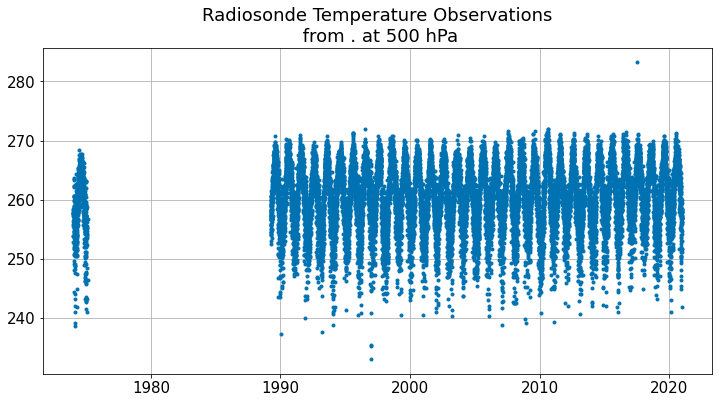

In [35]:
# Selecting only data for 500 hPa
with tdata.sel(obs=(tdata.plev==50000)) as tmp:
    plot(tmp.time, tmp.ta, marker='.', linestyle='')
    grid()
    title("Radiosonde Temperature Observations\n from {} at 500 hPa".format(tdata['station_id'].item(-1).decode()));

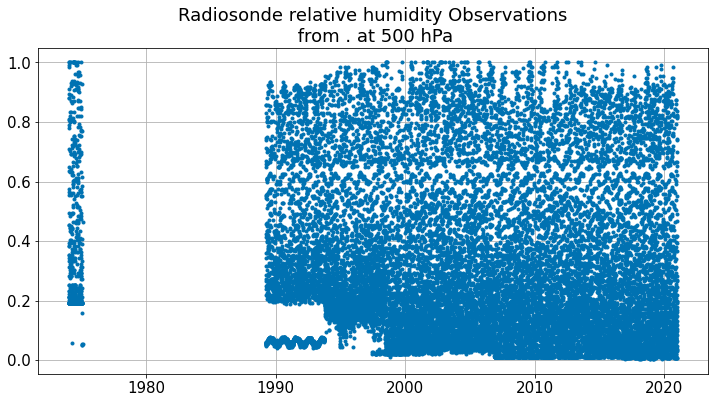

In [42]:
with rdata.sel(obs=(rdata.plev==50000)) as tmp:
    plot(tmp.time, tmp.hur, marker='.', linestyle='')
    grid()
    title("Radiosonde relative humidity Observations\n from {} at 500 hPa".format(rdata['station_id'].item(-1).decode()));

# Running the Homogenization Software

The following steps are completed automatically within this script:
1. Read data (`ifile`)
2. Look for required variables
    - Need observations and obs_minus_an or obs_minus_bg
3. Select only standard times (`0, 12`)
4. Convert to `hour x time x pressure` cubes
5. Calculate test statistics
6. Detect Breakpoints
7. Calculate Adjustments
8. Return/Write data

The Python script can also be run from the command line:

```bash
$ python raso_adj_cdm_v1.py -h

usage: raso_adj_cdm_v1.py [-h] [-f FRONTEND] [-b BACKEND] [-o OUTDIR] [-d DATES] [-p PLEVS] [--temperature] [--humidity] [--winds]
                          [--feedback FEEDBACK] [--feedback_group FEEDBACK_GROUP] [--homogenisation HOMOGENISATION] [--interpolate_missing]
                          [--copypart] [--debug] [--verbose] [--logfile LOGFILE]

Run standardized radiosonde homogenisation software on CDM compliant file

optional arguments:
  -h, --help            show this help message and exit
  -f FRONTEND, --frontend FRONTEND
                        CDM compliant file
  -b BACKEND, --backend BACKEND
                        CDM raw file
  -o OUTDIR, --outdir OUTDIR
                        Output directory
  -d DATES, --dates DATES
                        datetime selection, e.g. 2000-01-01,2020-12-31
  -p PLEVS, --plevs PLEVS
                        pressure level selection, e.g. 100,200,300,500,700,850
  --temperature         run adjustment on temperatures
  --humidity            run adjustment on humidities
  --winds               run adjustment on winds
  --feedback FEEDBACK   feedback variables
  --feedback_group FEEDBACK_GROUP
                        feedback group name (only backend files)
  --homogenisation HOMOGENISATION
                        homogenisation group name (only backend files)
  --interpolate_missing
                        interpolate missing values
  --copypart            copy only partial backendfile
  --debug               debug information
  --verbose             show more information
  --logfile LOGFILE     Logfile

Keyword options for Standard Normal Homogeneity Test (SNHT):
    --thres []          Threshold value for SNHT, default: 50
    --window []         Moving Window for SNHT, default: 1470 (in days, 4 years)
    --missing []        Maximum allowed missing values in window, default: 600 (in days)
    --min_levels []     Minimum required levels for significant breakpoint, default: 3
    --dist []           Minimum distance between breakpoints, default: 730 (in days, 2 years)
    --sample_size []    Minimum sample size for statistics, default: 130 (in days)
    --borders []        Breakpoint zone, default: 90 (in days)
    --ratio []          Use ratio instead of differences, default: 0 (not)

Examples:
    This will run the humidity bias estimation routine and write back the bias estimates into a group called
    advanced_homogenisation.

    >>> raso_adj_cdm_v1.py -b 0-20000-0-67001_CEUAS_merged_v1.nc --humidity 

version: 0.2
author: MB
date: Di 09 Mär 2021 16:18:08 CET
---------------------------------------------
```
**Notice: This script has been tested with some parameters, but not every combination has been tested. It is recommended for unexperienced users to use the default options and begin testing from there.**

## Run the script

In [43]:
# Call the script with the downloaded file
# You can add more options, but the default settings should be a good start.
!./raso_adj_cdm_v1.py -f example_data/1/dest_0-20000-0-72357_relative_humidity.nc --humidity 

/raid8/srvx1/mblaschek/.local/lib/python3.8/site-packages/ecmwflibs/__init__.py:131: UserWarning: ecmwflibs universal: found eccodes at /usr/local/lib/libeccodes.so
  warnings.warn(f"ecmwflibs universal: found {name} at {path}")
2021-06-25 14:37:52,551 - upperair.cdm | reopen - WARNING - reopen [r+] Copy file to example_data/1/dest_0-20000-0-72357_relative_humidity_adjusted.nc
2021-06-25 14:37:52,865 - upperair.cdm | align_datetime - WARNING - Conflicts [0, 12] [+/- 3]: 57 (# 115) of 23744
2021-06-25 14:37:52,878 - upperair.cdm | align_datetime - WARNING - Values are not sorted by standard_time


In [44]:
# Note that there is the adjustments file now
!ls example_data/1/

dest_0-20000-0-72357_air_temperature.nc
dest_0-20000-0-72357_relative_humidity_adjusted.nc
dest_0-20000-0-72357_relative_humidity.nc


In [45]:
!ncdump -h example_data/1/dest_0-20000-0-72357_relative_humidity_adjusted.nc

netcdf dest_0-20000-0-72357_relative_humidity_adjusted {
dimensions:
	obs = 1129977 ;
	string11 = 11 ;
	string14 = 14 ;
	string28 = 28 ;
	time = 1129977 ;
	trajectory = 24405 ;
variables:
	float bias_estimate(obs) ;
		bias_estimate:cdmname = "era5fb/biascorr@body" ;
		bias_estimate:units = "1" ;
		bias_estimate:coordinates = "lat lon time plev" ;
		bias_estimate:cdsname = "bias_estimate" ;
		bias_estimate:standard_name = "relative_humidity" ;
		bias_estimate:long_name = "ERA5 reanalysis bias_estimate" ;
	float hur(obs) ;
		hur:cdmname = "observations_table/observation_value" ;
		hur:units = "1" ;
		hur:coordinates = "lat lon time plev" ;
		hur:standard_name = "relative_humidity" ;
		hur:cdsname = "relative_humidity" ;
	float hur_bias_estimate(obs) ;
		hur_bias_estimate:cdmname = "observations_table/observation_value" ;
		hur_bias_estimate:cdsname = "relative_humidity" ;
		hur_bias_estimate:coordinates = "lat lon time plev" ;
		hur_bias_estimate:long_name = "ERA5 reanalysis obs_minus_bg

## Interactive in the Notebook

In [5]:
# this requires to load cds_eua3
import xarray as xr
import raso_adj_cdm_v1 as adj

2022-01-20 09:37:07,381 INFO Note: detected 160 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
2022-01-20 09:37:07,382 INFO Note: NumExpr detected 160 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-01-20 09:37:07,383 INFO NumExpr defaulting to 8 threads.


In [6]:
# Read the Data
iofile = adj.eua.CDMDataset('tocompare/cds_10393/dest_0-20001-0-10393_air_temperature.nc')
print(iofile)

File: <HDF5 file "dest_0-20001-0-10393_air_temperature.nc" (mode r)>
Filesize: 43.26 MB
Filename: tocompare/cds_10393/dest_0-20001-0-10393_air_temperature.nc
(G)roups/(V)ariables: 

 - V | RAOBCORE_bias_estimate_______________________ : : (1224748,)
 - V | RASE_bias_estimate___________________________ : : (1224748,)
 - V | RICH_bias_estimate___________________________ : : (1224748,)
 - V | RISE_bias_estimate___________________________ : : (1224748,)
 - V | bias_estimate________________________________ : : (1224748,)
 - V | lat__________________________________________ : : (1224748,)
 - V | lon__________________________________________ : : (1224748,)
 - V | obs_minus_bg_________________________________ : : (1224748,)
 - V | plev_________________________________________ : : (1224748,)
 - V | report_id____________________________________ : : (1224748, 11)
 - V | station_id___________________________________ : : (1224748, 20)
 - V | ta___________________________________________ : : (122474

In [9]:
# Convert to Cube
data = iofile.read_data_to_cube(['ta', 'bias_estimate'], dates=None, plevs=adj.std_plevs * 100)

2022-01-20 09:38:13,741 INFO [READ] plev : [  1000   2000   3000   5000   7000  10000  15000  20000  25000  30000
  40000  50000  70000  85000  92500 100000] [Pa]
2022-01-20 09:38:13,803 INFO [CUBE] ta (107956, 16)
2022-01-20 09:38:13,823 INFO [READ] plev : [  1000   2000   3000   5000   7000  10000  15000  20000  25000  30000
  40000  50000  70000  85000  92500 100000] [Pa]
2022-01-20 09:38:13,897 INFO [CUBE] bias_estimate (107956, 16)


In [10]:
data = xr.Dataset(data)
print(data)

<xarray.Dataset>
Dimensions:        (time: 107956, plev: 16)
Coordinates:
  * time           (time) datetime64[ns] 1905-04-04T06:00:00 ... 2020-12-31T1...
  * plev           (plev) int64 1000 2000 3000 5000 ... 70000 85000 92500 100000
Data variables:
    ta             (time, plev) float32 nan nan nan nan ... 267.3 272.7 nan
    bias_estimate  (time, plev) float32 nan nan nan nan ... 0.08833 0.115 nan


In [12]:
data = adj.adjustment_procedure(data, 
                                obs_name = 'ta', 
                                dep_name = 'bias_estimate', 
                                quantile_adjustments=True, # using quantile adjustments for humidity
                                mean_adjustments=False)

2022-01-20 09:38:21,471 WARNING Conflicts [0, 12] [+/- 3]: 3462 (# 7452) of 63728
2022-01-20 09:38:21,997 INFO Modified dates: 3990, Standard [0, 12]: 59738 / 48218 / 107956
2022-01-20 09:38:22,000 WARNING Values are not sorted by standard_time
2022-01-20 09:38:22,906 INFO Updated axis
2022-01-20 09:38:22,908 INFO SNHT from bias_estimate [test]
2022-01-20 09:38:23,275 INFO Breaks: [ 7136  8800  9832 10749 11827 13580 14672 15486 17596 22282 30737]
2022-01-20 09:38:23,278 INFO Breakpoints detected 0/0 : test_breaks
2022-01-20 09:38:23,291 INFO Breaks: [ 7050  8800 10311 11799 12552 13580 14670 17150 22436 30737]
2022-01-20 09:38:23,293 INFO Breakpoints detected 1/12 : test_breaks
2022-01-20 09:38:23,309 INFO Breakpoints: 11
2022-01-20 09:38:23,311 INFO Sample size: 10 N-Q: 13
2022-01-20 09:38:23,383 INFO Breakpoints: 10
2022-01-20 09:38:23,385 INFO Sample size: 10 N-Q: 13


In [13]:
print(data)

<xarray.Dataset>
Dimensions:        (time: 107956, plev: 16)
Coordinates:
  * time           (time) datetime64[ns] 1905-04-04T06:00:00 ... 2020-12-31T1...
  * plev           (plev) int64 1000 2000 3000 5000 ... 70000 85000 92500 100000
Data variables:
    ta             (time, plev) float32 nan nan nan nan nan ... nan nan nan nan
    bias_estimate  (time, plev) float32 nan nan nan nan nan ... nan nan nan nan
    test           (time, plev) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    breakpoints    (time, plev) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    adjustments    (time, plev) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0


### Interpolate to non-standard times and levels

On the command line add the option `interpolate_missing` and the adjustments will be interpolated to non-standard times and non-standard pressure levels.

**Notice: Takes a bit longer to run (+1:40 minutes)**

You can also do that in the Notebook, with the following command


In [59]:
# Interpolate vertically with log-linear in pressure
hur_interpol = data['hur'].groupby('time').apply(adj.eua.level_interpolation, 
                                                 dim = 'plev', 
                                                 method = 'log-linear', 
                                                 extrapolate = False)

In [60]:
print(hur_interpol)

<xarray.DataArray 'hur' (time: 24386, plev: 16)>
array([[       nan,        nan,        nan, ..., 0.73370767,        nan,
               nan],
       [       nan,        nan,        nan, ..., 0.1928271 ,        nan,
               nan],
       [       nan,        nan,        nan, ..., 0.25328264,        nan,
               nan],
       ...,
       [       nan, 0.097676  , 0.123331  , ..., 0.917217  , 0.936513  ,
               nan],
       [0.012977  , 0.031944  , 0.032756  , ..., 0.049654  , 0.690232  ,
               nan],
       [0.016745  , 0.022339  , 0.021731  , ..., 0.012895  , 0.287211  ,
               nan]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1974-01-01 ... 2020-12-31T12:00:00
  * plev     (plev) int64 1000 2000 3000 5000 7000 ... 70000 85000 92500 100000
Attributes:
    cdmname:        observations_table/observation_value
    cdsname:        relative_humidity
    coordinates:    lat lon time plev
    standard_name:  relative_humidity
    units:   

In [61]:
# Interpolate linear in time
# Interpolate adjustments per level backwards and forward in time
hur_interpol = hur_interpol.groupby('plev').apply(adj.eua.level_interpolation,
                                                 dim = 'time')

In [62]:
print(hur_interpol)

<xarray.DataArray 'hur' (time: 24386, plev: 16)>
array([[       nan,        nan,        nan, ..., 0.73370767,        nan,
               nan],
       [       nan,        nan,        nan, ..., 0.1928271 ,        nan,
               nan],
       [       nan,        nan,        nan, ..., 0.25328264,        nan,
               nan],
       ...,
       [0.017658  , 0.097676  , 0.123331  , ..., 0.917217  , 0.936513  ,
               nan],
       [0.012977  , 0.031944  , 0.032756  , ..., 0.049654  , 0.690232  ,
               nan],
       [0.016745  , 0.022339  , 0.021731  , ..., 0.012895  , 0.287211  ,
               nan]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1974-01-01 ... 2020-12-31T12:00:00
  * plev     (plev) int64 1000 2000 3000 5000 7000 ... 70000 85000 92500 100000
Attributes:
    cdmname:        observations_table/observation_value
    cdsname:        relative_humidity
    coordinates:    lat lon time plev
    standard_name:  relative_humidity
    units:   

### Check for interpolated adjustments

In [63]:
# Count the amount of levels per profile
isel = data['hur'].count('plev')
print(isel)

<xarray.DataArray 'hur' (time: 24386)>
array([ 4,  4,  4, ..., 14, 15, 15])
Coordinates:
  * time     (time) datetime64[ns] 1974-01-01 ... 2020-12-31T12:00:00


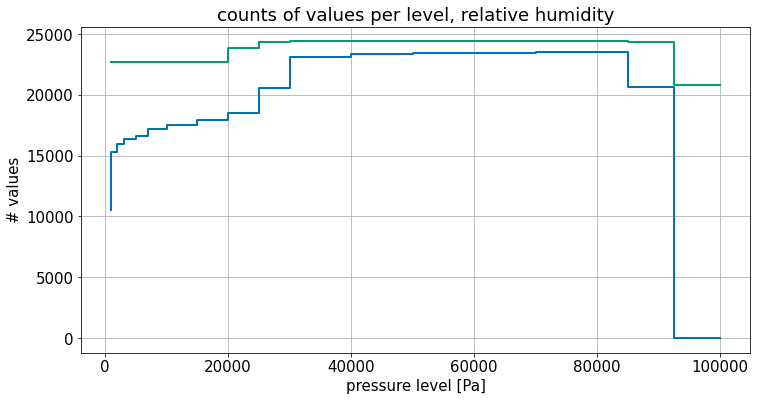

In [64]:
data.hur.count('time').plot.step()
hur_interpol.count('time').plot.step()
grid()
ylabel('# values')
xlabel('pressure level [Pa]')
title('counts of values per level, relative humidity');

### Plot Profile with interpolated adjustments

In [65]:
ident = "".join(iofile.station_id[-1].astype(str))
print(ident)

NORMAN/MAX WESTHEIMER A, OK.


AttributeError: 'Dataset' object has no attribute 'hur'

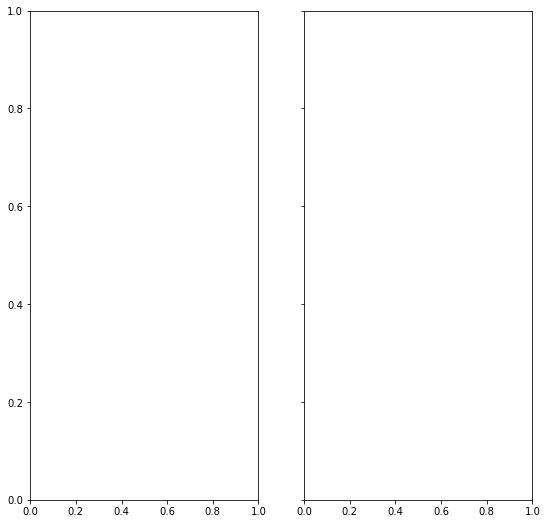

In [17]:
itime = '1997-12-23 12:00'
yplevs = adj.std_plevs*100
ylabels = map(str, adj.std_plevs)
f,ax = subplots(1,2, sharey=True, figsize=(9,9))
tmp = data.sel(time=itime)
tmp.hur.plot(y='plev', ax=ax[0], marker='+', mec='red' )
(tmp.hur - tmp.adjustments).plot(y='plev', ax=ax[0], marker='+', mec='red' )
tmp.adjustments.plot(y='plev', ax=ax[1], marker='+', mec='red')
ax[0].set_yticks(ticks=yplevs)
ax[0].set_yticklabels(ylabels)
ylim(100000,1000)
ax[0].grid()
ax[1].grid()
ax[1].set_ylabel('')
ax[0].set_xlabel('relative_humidity [1]')
ax[0].legend(['HUR', 'HUR + HUR_Q'])
f.suptitle("RASO {} Profile of relative humidty, adjustments\n {}".format(ident, itime), y=1.01);
tight_layout()

# Investigating results

The homogenization results can be interpreted by looking at the following:

* [Analysis departures](#Departures)
* [Test and Breakpoints](#SNHT-&-Breakpoints)
* [Adjustments](#Adjustments)

In [15]:
# simple plotting function for xarrays
def easy_plot(data, **kwargs):
    dims = list(data.dims)
    return contourf(data[dims[1]].values, data[dims[0]].values, data.values, **kwargs)

## Departures

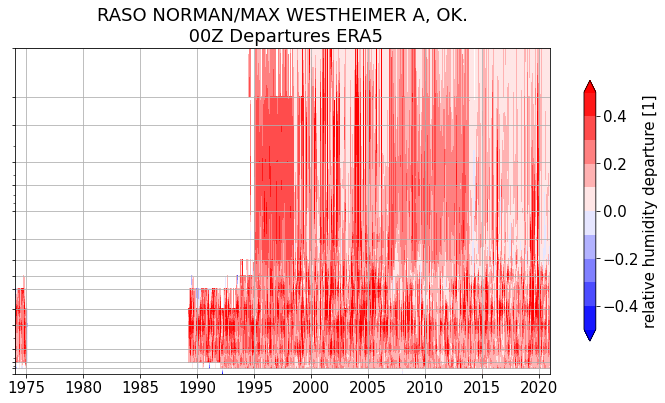

In [68]:
# Select only 00 Z times
figure(figsize=(12,6))
cs = easy_plot(data['obs_minus_bg'].sel(time=data.time.dt.hour.isin([0])).T, 
               levels=np.arange(-0.5,0.6,0.1),
               extend='both', 
               cmap='bwr')
grid()
colorbar(cs, label='relative humidity departure [1]', shrink=0.8);
yscale('log')
ylim(100000, 1000)
yticks(ticks=yplevs, labels=ylabels);
title("RASO {}\n 00Z Departures ERA5".format(ident));

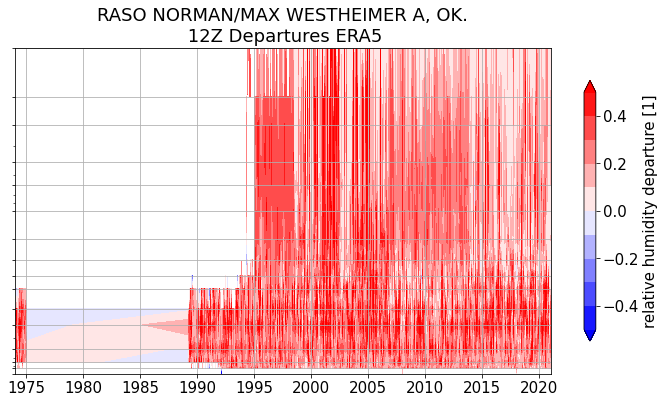

In [69]:
# select only 12 Z times
figure(figsize=(12,6))
cs = easy_plot(data['obs_minus_bg'].sel(time=data.time.dt.hour.isin([12])).T,  
               levels=np.arange(-0.5,0.6,0.1),
               extend='both', 
               cmap='bwr')
grid()
colorbar(cs, label='relative humidity departure [1]', shrink=0.8);
yscale('log')
ylim(100000, 1000)
yticks(ticks=yplevs, labels=ylabels);
title("RASO {}\n 12Z Departures ERA5".format(ident));

## SNHT & Breakpoints

Breakpoints: ['1957-09-24T00:00:00.000000000' '1960-03-30T00:00:00.000000000'
 '1963-03-15T00:00:00.000000000' '1968-01-02T00:00:00.000000000'
 '1973-03-22T00:00:00.000000000' '1978-12-31T00:00:00.000000000']


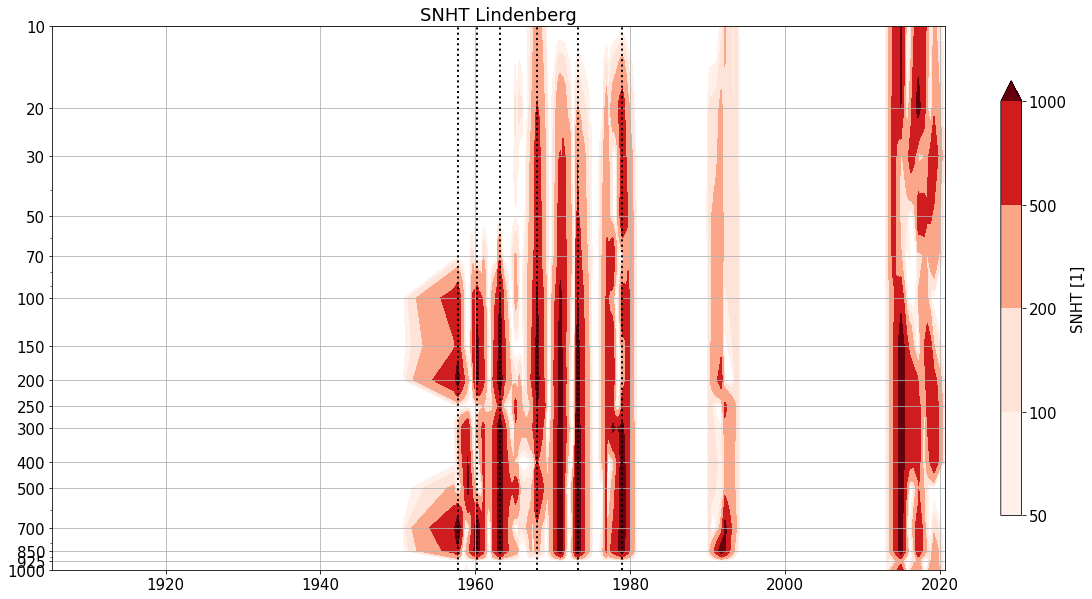

In [28]:
plt.rcParams['figure.figsize'] = [20.0, 10.0]
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.size'] = 15
plt.style.use('seaborn-colorblind')

yplevs = adj.std_plevs*100
ylabels = map(str, adj.std_plevs)
tmp = data.sel(time=data.time.dt.hour.isin([0]))
cs = easy_plot(tmp.test.T, 
               levels=[50,100,200,500,1000], 
               cmap='Reds', 
               extend='max')
ibreaks = np.where(any(tmp.breakpoints == 2, axis=1))[0]
for i in ibreaks:
    axvline(x=tmp['time'].values[i], color='k', ls=':')
print("Breakpoints:", tmp['time'].values[ibreaks])
grid()
colorbar(cs, label='SNHT [1]', shrink=0.8);
yscale('log')
ylim(100000, 1000)
yticks(ticks=yplevs, labels=ylabels);
title("SNHT Lindenberg");

Breakpoints: ['1998-05-31T12:00:00.000000000' '2006-10-31T12:00:00.000000000'
 '2013-10-23T12:00:00.000000000']


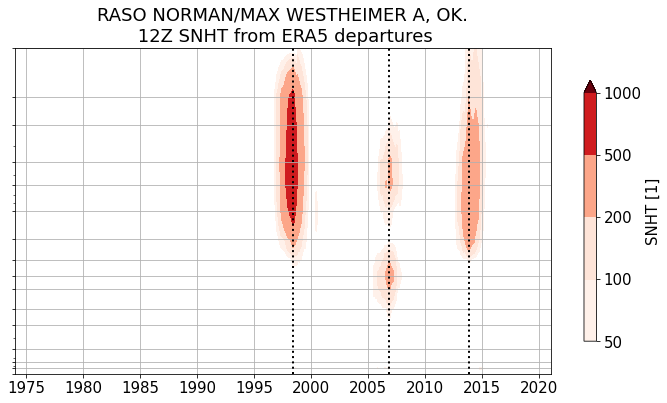

In [72]:
tmp = data.sel(time=data.time.dt.hour.isin([12]))
cs = easy_plot(tmp.test.T, 
               levels=[50,100,200,500,1000], 
               cmap='Reds', 
               extend='max')
ibreaks = np.where(any(tmp.breakpoints == 2, axis=1))[0]
for i in ibreaks:
    axvline(x=tmp['time'].values[i], color='k', ls=':')
print("Breakpoints:", tmp['time'].values[ibreaks])
grid()
colorbar(cs, label='SNHT [1]', shrink=0.8);
yscale('log')
ylim(100000, 1000)
yticks(ticks=yplevs, labels=ylabels);
title("RASO {}\n 12Z SNHT from ERA5 departures".format(ident));

## Adjustments

The adjustments need to be applied (added) to the field of relative humdity

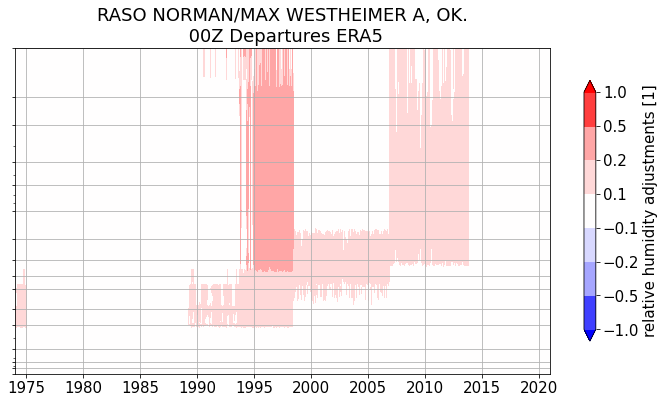

In [73]:
tmp = data.sel(time=data.time.dt.hour.isin([0]))
cs = easy_plot(tmp.adjustments.T, 
               levels=[-1,-0.5,-0.2,-0.1,0.1,0.2,0.5,1],
               extend='both', 
               cmap='bwr')
grid()
colorbar(cs, label='relative humidity adjustments [1]', shrink=0.8);
yscale('log')
ylim(100000, 1000)
yticks(ticks=yplevs, labels=ylabels);
title("RASO {}\n 00Z Departures ERA5".format(ident));

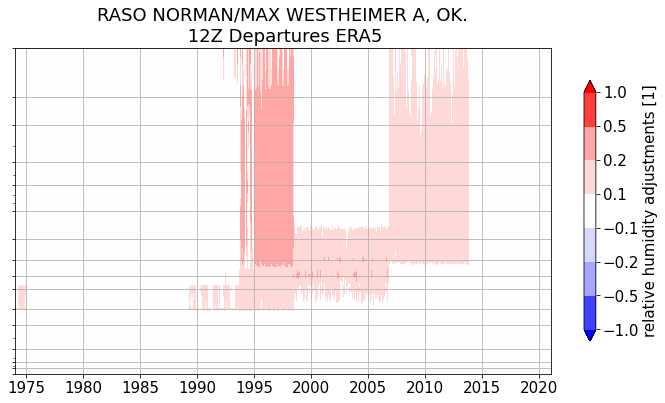

In [76]:
tmp = data.sel(time=data.time.dt.hour.isin([12]))
cs = easy_plot(tmp.adjustments.T, 
               levels=[-1,-0.5,-0.2,-0.1,0.1,0.2,0.5,1],
               extend='both', 
               cmap='bwr')
grid()
colorbar(cs, label='relative humidity adjustments [1]', shrink=0.8);
yscale('log')
ylim(100000, 1000)
yticks(ticks=yplevs, labels=ylabels);
title("RASO {}\n 12Z Departures ERA5".format(ident));

## Original vs Adjusted

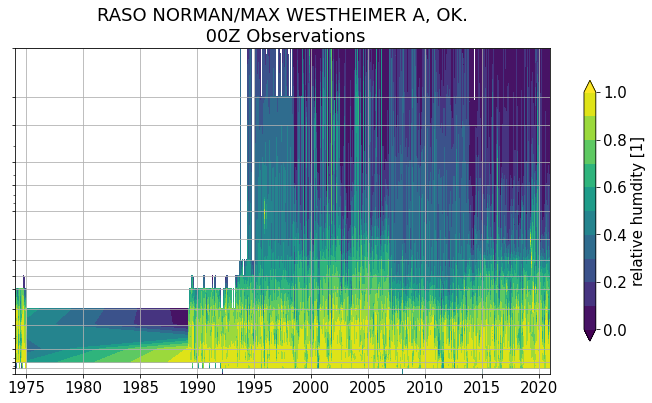

In [77]:
tmp = data.sel(time=data.time.dt.hour.isin([0]))
cs = easy_plot(tmp.hur.T,
               extend='both', 
               levels=np.arange(0,1.1,0.1))
grid()
colorbar(cs, extend='both', label='relative humdity [1]', shrink=0.8);
yscale('log')
ylim(100000, 1000)
yticks(ticks=yplevs, labels=ylabels);
title("RASO {}\n 00Z Observations".format(ident));

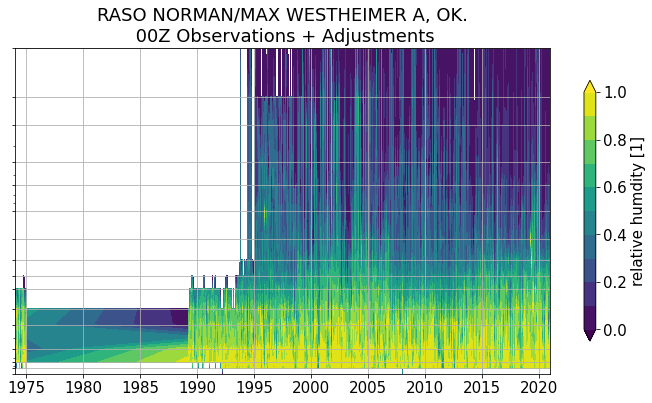

In [78]:
# unbiased = obs - bias
cs = easy_plot((tmp.hur - tmp.adjustments).T,
               extend='both', 
               levels=np.arange(0,1.1,0.1))
grid()
colorbar(cs, extend='both', label='relative humdity [1]', shrink=0.8);
yscale('log')
ylim(100000, 1000)
yticks(ticks=yplevs, labels=ylabels);
title("RASO {}\n 00Z Observations + Adjustments".format(ident));

## Vertical

Comparison of medians from unadjusted observations and adjusted observations as well as ERA5.

In [79]:
import pandas as pd

In [80]:
tmp = data.sel(time=data.time.dt.hour.isin([0]))
idata = pd.DataFrame(tmp['hur'].values, 
                     index=tmp['time'].values, 
                     columns=tmp['plev'].values)
idata.columns = (idata.columns/100).astype(int)

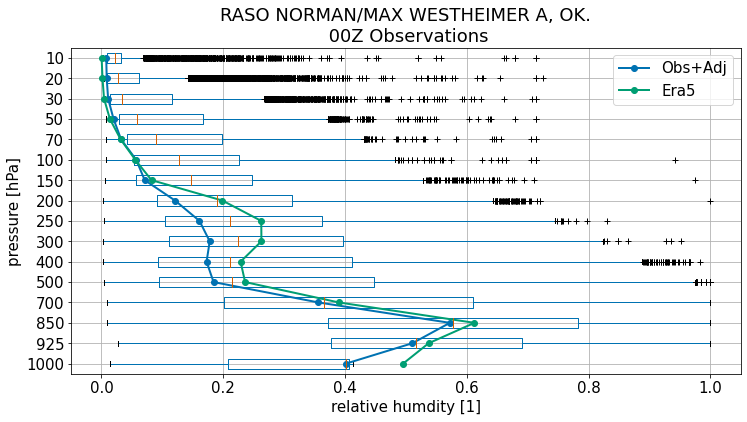

In [85]:
idata = idata.sort_index(axis=1, ascending=False)
ax = idata.boxplot(vert=False, return_type='axes', sym='+')
# median of adjusted obeservations
ax.plot((tmp['hur'] - tmp['adjustments']).median('time').to_dataframe('adj')['adj'].values,np.arange(16,0,-1), label='Obs+Adj', marker='o')
# obs - (obs - bg) = bg
ax.plot((tmp['hur'] - tmp['obs_minus_bg']).median('time').to_dataframe('era')['era'].values,np.arange(16,0,-1), label='Era5', marker='o')
ylabel('pressure [hPa]')
xlabel('relative humdity [1]');
legend()
title("RASO {}\n 00Z Observations".format(ident));